<a href="https://colab.research.google.com/github/Nathan-Roll1/ProsodPy/blob/main/Tutorials/prep_training_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# mount data from Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#--------------------------------------------------------------

Mounted at /content/drive


In [ ]:
# set random seed
from numpy.random import seed
seed(42)
#--------------------------------------------------------------

In [ ]:
# install backwards compatible version of Tensorflow ----------
!pip install tensorflow==2.7.0
import tensorflow as tf
print(tf.__version__)
#--------------------------------------------------------------

In [ ]:
#import modules
#--------------------------------------------------------------
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import re
import librosa   
import pickle
import shutil
import gc

from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Input, Lambda, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras import optimizers
#--------------------------------------------------------------

In [ ]:
# define MFCC segments for train/test purposes ---------------
set_indices = {'pre':'[:,:512]',
               'h_pre':'[:,256:512]',
               'bound':'[:,lower_mid:upper_mid]',
               'h_bound':'[:,lower_mid+128:upper_mid-128]',
               'post':'[:,-512:][:,::-1]',
               'h_post':'[:,-256:][:,::-1]'}
#--------------------------------------------------------------

# One Time Merging [Run only once]

In [ ]:
# create list of file suffixes
ns = [f'{x:02d}' for x in range(1,61)]

In [ ]:
# carry over naming convention from Data_Generation
tail = "_hop16_coef15_normalized"

In [ ]:
# merge and save joined label file ---------------------------
y_s = []
for i, n in enumerate(tqdm(ns)):
  with open(f'drive/Shareddrives/Ling Thesis/PREPROCESSED/labels/{n}{tail}.pickle', 'rb') as handle:
    y_s.append(pickle.load(handle))

y = np.concatenate(y_s)
del y_s

with open(f'drive/Shareddrives/Ling Thesis/PREPROCESSED/Joined/y.pickle', 'wb') as handle:
  pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

del y
#--------------------------------------------------------------

100%|██████████| 60/60 [00:39<00:00,  1.51it/s]


In [ ]:
# merge and save joined feature file --------------------------
feats = []

for i, n in enumerate(tqdm(ns)):
  with open(f'drive/Shareddrives/Ling Thesis/PREPROCESSED/features/{n}{tail}.pickle', 'rb') as handle:
    feats.append(pickle.load(handle))
feats = np.concatenate(feats).transpose(0,2,1)

with open(f'drive/Shareddrives/Ling Thesis/PREPROCESSED/Joined/X.pickle', 'wb') as handle:
  pickle.dump(feats, handle, protocol=pickle.HIGHEST_PROTOCOL)
del feats
#--------------------------------------------------------------

100%|██████████| 60/60 [02:50<00:00,  2.85s/it]


# Init

In [ ]:
# load features and labels ------------------------------------
with open(f'drive/Shareddrives/Ling Thesis/PREPROCESSED/Joined/X.pickle', 'rb') as handle:
  X = pickle.load(handle)

with open('drive/Shareddrives/Ling Thesis/PREPROCESSED/Joined/y.pickle', 'rb') as handle:
  y = pickle.load(handle)
#--------------------------------------------------------------

In [ ]:
# verify matching feat/lab lengths (128508)
X.shape, y.shape 

((128508, 1024, 15), (128508,))

In [ ]:
# get boundary point
h = X.shape[1]/2

# ... and 1/4|3/4 points
lower_mid, upper_mid = int(h-h/2),int(h+h/2)

In [ ]:
# generate shuffle pattern
shuffler = np.random.RandomState(seed=42).permutation(len(X)) 

# split train and test sets (validation during training)
train_test_split_index = round(len(y)*.9)

# shuffle features ---------------------------------------
X = X[shuffler] 
X_train = X[:train_test_split_index]
X_test = X[train_test_split_index:]
#---------------------------------------------------------

#... and labels ------------------------------------------
y = y[shuffler] 
y_train = y[:train_test_split_index]
y_test = y[train_test_split_index:]
#---------------------------------------------------------

In [ ]:
#... set image parameters --------------------------------
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["figure.dpi"] = 250
#---------------------------------------------------------

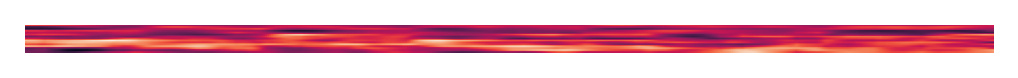

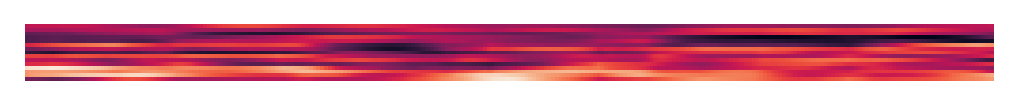

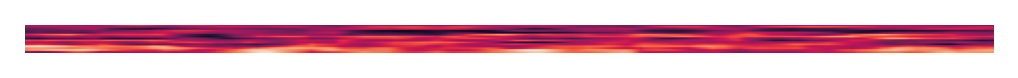

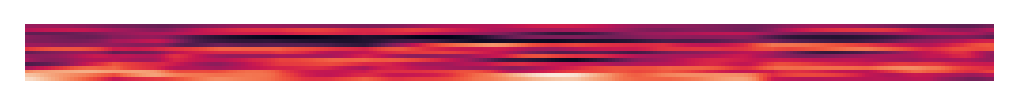

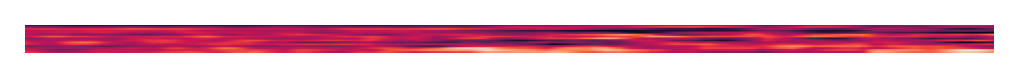

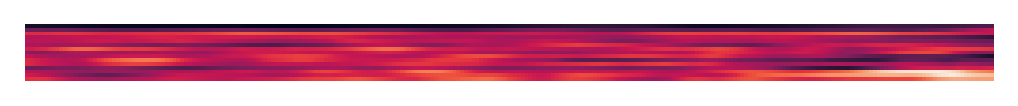

In [ ]:
#... plot sample sets ------------------------------------
for k, s in set_indices.items():
  plt.imshow(eval(f'X{s}')[0].T)
  plt.axis('off')
  plt.show()
#---------------------------------------------------------

# RNN

In [ ]:
# define rnn architecture ---------------------------------------------------------------
def rnn_model(k,i):

  #specify path to save
  path = f'drive/Shareddrives/Ling Thesis/checkpoints/rnn_checkpoints_{k}'
  print(path)

  #remove anything existing at path
  try:
    os.mkdir(path)
  except:
    shutil.rmtree(path)
    os.mkdir(path)

  # define checkpoint w/ naming convention
  checkpoint_rnn = ModelCheckpoint(f'{path}/{k}'+'_rnn-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

  # init sequential model
  rnn_model = Sequential()

  # define layers
  rnn_model.add(LSTM(128, return_sequences=True, recurrent_dropout=0,dropout=0.2,recurrent_activation='sigmoid'))
  rnn_model.add(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0,recurrent_activation='sigmoid'))
  rnn_model.add(Dense(32, activation='tanh'))
  rnn_model.add(Dropout(.2))
  rnn_model.add(Dense(1, activation='sigmoid'))

  rnn_model.compile(optimizer='adam', loss='MSE')

  # train on given subset (i)
  rnn_model.fit(eval(f'X_train{i}'),  y_train, batch_size=512, epochs=45, callbacks=[checkpoint_rnn], validation_split=1/9)
# -------------------------------------------------------------------------------------------

In [ ]:
# run rnn on all sets specified in 'Setup' --------------------------
for k, i in set_indices.items():

  # clear GPU memory
  tf.keras.backend.clear_session()
  gc.collect()

  # build/train/save model
  rnn_model(k,i)
# --------------------------------------------------------------------

# CNN

In [ ]:
# define cnn architecture ---------------------------------------------------------------
def cnn_model(k,i):

  #specify path to save
  path = f'drive/Shareddrives/Ling Thesis/checkpoints/cnn_checkpoints_{k}'
  print(path)

  #remove anything existing at path
  try:
    os.mkdir(path)
  except:
    shutil.rmtree(path)
    os.mkdir(path)

  # define checkpoint w/ naming convention
  checkpoint_cnn = ModelCheckpoint(f'{path}/{k}'+'_cnn-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

  # init sequential model
  cnn_model = Sequential()

  # define layers
  cnn_model = Sequential()
  cnn_model.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
  cnn_model.add(Conv2D(filters=64,kernel_size=2,padding="valid",activation="relu"))
  cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(8, activation='tanh'))
  cnn_model.add(Dropout(.2))
  cnn_model.add(Dense(1, activation='sigmoid'))

  cnn_model.compile(optimizer='adam', loss='MSE')

  # reshape for convolutional layers
  xx = np.expand_dims(eval(f'X_train{i}'),3)

  # train on given subset (i)
  rnn_model.fit(xx,  y_train, batch_size=512, epochs=45, callbacks=[checkpoint_cnn], validation_split=1/9)
# -------------------------------------------------------------------------------------------

In [ ]:
# run rnn on all sets specified in 'Setup' --------------------------
for k, i in set_indices.items():

  # clear GPU memory
  tf.keras.backend.clear_session()
  gc.collect()

  # build/train/save model
  cnn_model(k,i)
# --------------------------------------------------------------------

# OLS

In [ ]:
# define function to retrieve the best models (on validation) --------------------------
def get_best_callbacks():
  models = []
  for k,i in set_indices.items():
    for mtype in ['cnn','rnn']:
      path = f'drive/Shareddrives/Ling Thesis/checkpoints/{mtype}_checkpoints_{k}/'
      nns = os.listdir(path)
      max_epoch = max([x.split('-')[1] for x in nns])
      nn =  [x for x in nns if x.split('-')[1] == max_epoch][0]
      models.append(((k,i),path+nn))
  return models
# --------------------------------------------------------------------------------------

In [ ]:
# generate individual model predictions ------------------------------------------------

# call prior function, save to 'models' variable
models = get_best_callbacks()

# create empty prediction dictionary
preds = {}

# for each model...
for l,m in models:

  # clear GPU cache
  tf.keras.backend.clear_session()
  gc.collect()

  # print subset and model path
  print(l[0],m)
  
  # load the model
  model = tf.keras.models.load_model(m)

  # predict and save to pred dictionary
  if 'rnn' in m:
    preds[m] = model.predict(eval(f'X{l[1]}'))
  else:
    preds[m] = model.predict(np.expand_dims(eval(f'X{l[1]}'),3))

  # delete model from memory
  del model
# --------------------------------------------------------------------------------------

pre drive/Shareddrives/Ling Thesis/checkpoints/cnn_checkpoints_pre/pre_cnn-040-0.218414-0.221026.h5
pre drive/Shareddrives/Ling Thesis/checkpoints/rnn_checkpoints_pre/pre_rnn-026-0.201815-0.212274.h5
h_pre drive/Shareddrives/Ling Thesis/checkpoints/cnn_checkpoints_h_pre/h_pre_cnn-039-0.219750-0.220789.h5
h_pre drive/Shareddrives/Ling Thesis/checkpoints/rnn_checkpoints_h_pre/h_pre_rnn-015-0.206083-0.214536.h5
bound drive/Shareddrives/Ling Thesis/checkpoints/cnn_checkpoints_bound/bound_cnn-040-0.209112-0.211751.h5
bound drive/Shareddrives/Ling Thesis/checkpoints/rnn_checkpoints_bound/bound_rnn-007-0.245546-0.246018.h5
h_bound drive/Shareddrives/Ling Thesis/checkpoints/cnn_checkpoints_h_bound/h_bound_cnn-038-0.213775-0.216071.h5
h_bound drive/Shareddrives/Ling Thesis/checkpoints/rnn_checkpoints_h_bound/h_bound_rnn-045-0.208116-0.212998.h5
post drive/Shareddrives/Ling Thesis/checkpoints/cnn_checkpoints_post/post_cnn-029-0.228427-0.234005.h5
post drive/Shareddrives/Ling Thesis/checkpoints/r

In [ ]:
# create dataframe from predictions and save --------------------------------------------

# initialize empty dataframe
df = pd.DataFrame()

# for each key/value pair in prediction dict...
for c,d in preds.items():

  # make col[key] = value
  df[c] = [x[0] for x in d]

# add labels column
df['label'] = y

# save the dataframe
with open(f'drive/Shareddrives/Ling Thesis/Final Models/pred_df.pickle', 'wb') as handle:
  pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# --------------------------------------------------------------------------------------

In [ ]:
# raname columns from model file to set name ------------------
col_order = []

for col in df.columns:
  if 'drive' in col:
    col_order.append(col.split('/')[-1].split('-')[0])
# -------------------------------------------------------------

In [ ]:
# safe col order before losing names in OLS ------------------
with open('drive/Shareddrives/Ling Thesis/Final Models/feed_order.pickle', 'wb') as handle:
  pickle.dump(col_order, handle, protocol=pickle.HIGHEST_PROTOCOL)
# -------------------------------------------------------------

In [ ]:
# train and evaluate regression -------------------------------

# fit OLS to training set
model = LinearRegression()
model = LinearRegression().fit(df.values[:,:-1][:train_test_split_index], df.values[:,-1][:train_test_split_index])

# evaluate on test set (r^2)
print(model.score(df.values[:,:-1][train_test_split_index:], df.values[:,-1][train_test_split_index:]))

# ... and train set (r^2)
print(model.score(df.values[:,:-1][:train_test_split_index], df.values[:,-1][:train_test_split_index]))

# create new column in DF with OLS predictions
df['OLS'] = model.predict(df.values[:,:-1])
# -------------------------------------------------------------

0.2556683333821138
0.26664389676656264


In [ ]:
# save model
with open(f'drive/Shareddrives/Ling Thesis/Final Models/OLS.pickle', 'wb') as handle:
  pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# evaluate all models -----------------------------------------
# create baseline prediction column
df['ones'] = 1

# evaluate metrics at thresholds of 0.37 and 0.5
d = {}
d1 = {}
for d_i,t in zip([d,d1],[0.5,0.37]):
  for col in df.columns:
    if col not in ['label']:
      name = col.split('/')[-1].split('-')[0]
      print(name)

      y_actual = df['label'][train_test_split_index:]
      preds = df[col][train_test_split_index:]
      y_pred = preds >= t
      d_i[name] = [f1_score(y_actual, y_pred),precision_score(y_actual, y_pred),
                      recall_score(y_actual, y_pred),accuracy_score(y_actual, y_pred)]
# -------------------------------------------------------------

pre_cnn
pre_rnn
h_pre_cnn
h_pre_rnn
bound_cnn
bound_rnn
h_bound_cnn
h_bound_rnn
post_cnn
post_rnn
h_post_cnn
h_post_rnn
OLS
ones
pre_cnn
pre_rnn
h_pre_cnn
h_pre_rnn
bound_cnn
bound_rnn
h_bound_cnn
h_bound_rnn
post_cnn
post_rnn
h_post_cnn
h_post_rnn
OLS
ones


In [ ]:
# format evaluation results @ 0.37 ----------------------------------
results_df = pd.DataFrame(d).T.sort_values(by=3,ascending=False)
results_df.columns = ['F1','Precision','Recall','Accuracy']
results_df.to_latex(index=True,float_format="%.3f")
# -------------------------------------------------------------------

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &    F1 &  Precision &  Recall &  Accuracy \\\\\n\\midrule\nOLS         & 0.719 &      0.728 &   0.709 &     0.724 \\\\\npre\\_rnn     & 0.683 &      0.707 &   0.660 &     0.695 \\\\\nh\\_pre\\_rnn   & 0.679 &      0.693 &   0.666 &     0.687 \\\\\nh\\_bound\\_rnn & 0.680 &      0.660 &   0.701 &     0.671 \\\\\nbound\\_cnn   & 0.648 &      0.676 &   0.622 &     0.663 \\\\\nh\\_bound\\_cnn & 0.657 &      0.655 &   0.659 &     0.658 \\\\\nh\\_pre\\_cnn   & 0.645 &      0.636 &   0.655 &     0.642 \\\\\npre\\_cnn     & 0.628 &      0.641 &   0.615 &     0.637 \\\\\npost\\_rnn    & 0.614 &      0.650 &   0.582 &     0.636 \\\\\npost\\_cnn    & 0.591 &      0.602 &   0.580 &     0.600 \\\\\nbound\\_rnn   & 0.556 &      0.562 &   0.551 &     0.562 \\\\\nh\\_post\\_rnn  & 0.530 &      0.566 &   0.499 &     0.560 \\\\\nh\\_post\\_cnn  & 0.537 &      0.553 &   0.522 &     0.552 \\\\\nones        & 0.665 &      0.498 &   1.000 &     0.498 \\\\\n\\bottomru

In [ ]:
# format evaluation results @ 0.5 -----------------------------------
results_df = pd.DataFrame(d1).T.sort_values(by=0,ascending=False)
results_df.columns = ['F1','Precision','Recall','Accuracy']
results_df.to_latex(index=True,float_format="%.3f")
# -------------------------------------------------------------------

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &    F1 &  Precision &  Recall &  Accuracy \\\\\n\\midrule\nOLS         & 0.739 &      0.650 &   0.855 &     0.699 \\\\\npre\\_rnn     & 0.717 &      0.622 &   0.845 &     0.668 \\\\\nh\\_pre\\_rnn   & 0.709 &      0.605 &   0.854 &     0.650 \\\\\nh\\_bound\\_rnn & 0.703 &      0.595 &   0.859 &     0.639 \\\\\nbound\\_cnn   & 0.694 &      0.607 &   0.812 &     0.644 \\\\\nh\\_bound\\_cnn & 0.693 &      0.586 &   0.849 &     0.627 \\\\\nh\\_pre\\_cnn   & 0.683 &      0.566 &   0.859 &     0.603 \\\\\npost\\_rnn    & 0.681 &      0.565 &   0.857 &     0.601 \\\\\npre\\_cnn     & 0.679 &      0.573 &   0.833 &     0.608 \\\\\npost\\_cnn    & 0.666 &      0.536 &   0.879 &     0.561 \\\\\nh\\_post\\_rnn  & 0.665 &      0.498 &   1.000 &     0.498 \\\\\nbound\\_rnn   & 0.665 &      0.498 &   1.000 &     0.498 \\\\\nones        & 0.665 &      0.498 &   1.000 &     0.498 \\\\\nh\\_post\\_cnn  & 0.663 &      0.499 &   0.989 &     0.500 \\\\\n\\bottomru

In [ ]:
# bound regression output by [0,1]
df['OLS'] = np.clip(df['OLS'],0,1)

In [ ]:
# test metrics at all thresholds ------------------------------------
d = {}

# for each threshold...
for threshold in np.linspace(0,1,201):

  # take actual labels from dataframe
  y_actual = df['label']

  # binary predictions from True/False comparison to given threshold
  y_pred = df['OLS'] >= threshold

  # add test set predictions to dictionary
  d[threshold] = [f1_score(y_actual[train_test_split_index:], y_pred[train_test_split_index:]),precision_score(y_actual[train_test_split_index:], y_pred[train_test_split_index:]),
                  recall_score(y_actual[train_test_split_index:], y_pred[train_test_split_index:]),accuracy_score(y_actual[train_test_split_index:], y_pred[train_test_split_index:])]
# --------------------------------------------------------------------

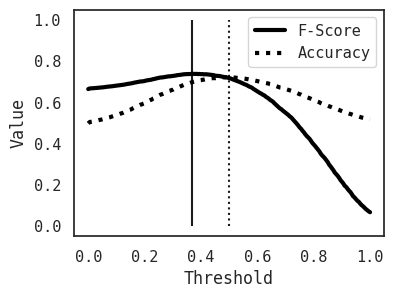

In [ ]:
# create plot --------------------------------------------------------

# set image parameters
sns.set_style("white")
plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.family"] = "monospace"

# plot each series
plt.plot(np.linspace(0,1,201),[x[0] for x in list(d.values())],label='F-Score',linestyle='-',c='black',linewidth=3)
plt.plot(np.linspace(0,1,201),[x[3] for x in list(d.values())],label='Accuracy',linestyle=':',c='black',linewidth=3)

# plot score-maximizing vertical lines
plt.vlines(0.37,0,1,linestyle='-')
plt.vlines(0.5,0,1,linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
# --------------------------------------------------------------------

In [ ]:
# get best F-score
matrix = pd.DataFrame(d).T
matrix[matrix[0]==max(matrix[0])][0]

0.37    0.738811
Name: 0, dtype: float64

In [ ]:
# get best accuracy
matrix[matrix[3]==max(matrix[3])][3]

0.5    0.723601
Name: 3, dtype: float64

Text(0, 0.5, 'Frequency')

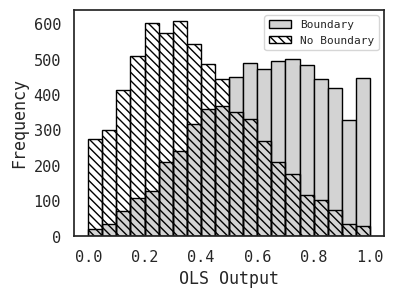

In [ ]:
# create dual histogram plot -----------------------------------------
df2 = df.iloc[train_test_split_index:]
plt.hist(df2[df2['label']==1]['OLS'],label='Boundary',bins=20,log=False, edgecolor='black',color='lightgray')
plt.hist(df2[df2['label']==0]['OLS'],label='No Boundary',bins=20,log=False,hatch='\\\\\\\\', edgecolor='black',fill=False)

plt.legend(loc='upper right',prop={'size': 8})
plt.xlabel('OLS Output')
plt.ylabel('Frequency')
# --------------------------------------------------------------------

# Predictions with evaluation transcripts (use inference tutorial for untranscribed audio)

In [ ]:
# path to resampled discourse audio
init_path = 'drive/Shareddrives/Ling Thesis/resampled/'

# get name of each file
fs = os.listdir(init_path)

# merge names with path to generate full path
fs = [init_path + x for x in fs]

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import librosa   
import pickle

def get_boundaries(fpath):
  '''Parse .cha file and extract timestamps'''

  # read in file as string
  with open(fpath) as f: 
    t = f.read()

  # split at occurences of \x15 unicode character (denote beginning/end of timestamp)
  a = t.split('\x15') 

  # get odd numbered values (in between the break chars)
  IUs = [x for i,x in enumerate(a) if i%2==1]

  # split substrings by underscore to separate beginning and end
  boundaries = [x.split('_') for x in IUs]

  # for each boundary, store time values
  a = []
  for b in boundaries:
    a.append(int(b[0]))
    a.append(int(b[1]))

  # sort extracted bounds
  boundaries = sorted(list(set(a))) 

  # convert to seconds
  boundaries = (np.array(boundaries))/1000 
  return boundaries



def moving_average(a, n=200):
  '''smooths input array with a window of n'''

  # get cumulative sum for each point
  ret = np.cumsum(a, dtype=float)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n



def bound_opts(audio_array,transcribed_bounds, start):
  '''Returns true and false IU heuristic boundaries \ngiven array-type audio data and transcribed labels'''
  
  # remove sign and smooth out noise
  abs_arr = moving_average(np.abs(audio_array),n=200) 

  # take every nth value
  abs_arr = abs_arr[::200] 

  # if value is smaller than it's neighbors, append to list of potential bounds
  t_f = (abs_arr<np.roll(abs_arr,1))&(abs_arr<np.roll(abs_arr,-1)) 

  # returns indicies of potential bounds
  boundary_options = np.where(t_f==1)[0] 

  # algorithm: if removing a boundary wouldn't include meaningful sound, then remove it
  for j in range(len(boundary_options)): 
    for i,b in enumerate(boundary_options):
      if i < len(boundary_options)-2:

        # arbitrary pause threshold of the standard deviation of abs values divided by 5
        if max(abs_arr[b:boundary_options[i+2]]) < np.std(abs_arr)/5: 
          boundary_options = np.delete(boundary_options, [i+1], axis=0)

  # realign heuristic bounds to initial sample rate
  boundary_options = boundary_options*200+100 + start
  
  # to apply heuristic only
  if type(transcribed_bounds) == bool:
    if transcribed_bounds == False:
      return boundary_options

  # snap transcribed bounds to closest heuristic bound
  true_labels = []
  for t_b in transcribed_bounds:
    abs_diff = np.abs(boundary_options-t_b)
    m = np.argmin(abs_diff)
    if m <= 400:
      true_labels.append(m)

  # append true and false labels by index
  false_labels = np.array([boundary_options[i] for i in range(len(boundary_options)) if i not in true_labels])
  true_labels = np.array([boundary_options[i] for i in range(len(boundary_options)) if i in true_labels])

  return true_labels, false_labels



def gen_data(audio_array, boundaries, plot=False):
  '''generates boundary position and label for audio file and accompanying boundaries'''

  # define number of 5-second segments (and one final partial segment with remainder)
  segments = int(np.ceil(len(audio_array)/20000)) 

  # initialize X and y
  X, y = [],[]

  # get true and false boundaries for each segment
  for i in range(segments):

    # segments defined by start and stop sample number
    start, stop = (20000*i,20000*(i+1))

    # subset complete audio file to isolate chunk
    chunk = audio_array[start:stop]

    # relevant boundaries only exist with the segment
    bound_set = boundaries[np.where(np.logical_and(boundaries>=start, boundaries<=stop))[0]]

    # concatenate all segment data together
    try: #catches case where segment contains no potential boundaries
      true_labels, false_labels = bound_opts(chunk, bound_set, start)

      X += list(true_labels) #preserve order of features
      X += list(false_labels)
      y += [1]*len(true_labels) #... and labels
      y += [0]*len(false_labels)

      # plots each segment if specified
      if plot: 

        # plot audio
        plt.plot(range(start,stop),chunk)

        # plot false potential boundaries
        plt.vlines(false_labels,np.min(chunk),np.max(chunk),linewidth=2,color='r')

        # plot true potential boundaries
        plt.vlines(true_labels,np.min(chunk),np.max(chunk),linewidth=2,color='g')

        # plot unaltered timestamps
        plt.vlines(bound_set,np.min(chunk),np.max(chunk),linewidth=2,linestyle='--')
        plt.show()

    except Exception as E: # empty segment cases are ignored
      # print(E)
      pass
    
  return np.array(X), np.array(y)



def return_feats(MFCC, X, hop_length, n_frames):
  '''defines window ranges for relevant MFCC data'''
  
  # boundary data from 156 frame radius (312 total)
  R_3 = MFCC[:,int(np.floor(X/hop_length))-round(n_frames/2):int(np.floor(X/hop_length))+round(n_frames/2)]

  return R_3



def MFCC_preprocess(audio_array, boundaries, hop_length=32, n_mfcc = 12, n_fft=743, n_frames = 312, normalize=True):
  '''returns preprocessed MFCC data for an audio file'''

  # initialize empty lists to append data to
  boundary_mfcc, labels, usable_bounds = [],[],[]

  # store length of audio (in samples)
  l = len(audio_array)

  # generate MFCC (n_fft proportional to 2048 @ 22050hz)
  MFCC = librosa.feature.mfcc(audio_array, n_mfcc = n_mfcc, n_fft=n_fft, hop_length=hop_length)

  # normalize MFCC
  if normalize:
    MFCC = ((MFCC.T-MFCC.mean(axis=1))/MFCC.std(axis=1)).T

  # store X and y from data generation function
  X, y = gen_data(audio_array, boundaries, plot=False)
        
  # append data to corresponding lists
  for feat,lab in zip(X,y):

    # buffer defined as total sampled needed (number of frames * len of each frame)
    buffer = n_frames*hop_length
    
    
    # only run boundaries which can be fully evaluated
    if (feat > buffer)&(feat<(l-buffer)):
      usable_bounds.append(feat)

      # generate pre/post/boundary segments
      R_3 = return_feats(MFCC, feat, hop_length, n_frames)

      # append to lists
      boundary_mfcc.append(R_3)
      labels.append(lab)

  # convert lists to numpy arrays
  boundary_mfcc = np.array(boundary_mfcc)
  labels = np.array(labels)
  usable_bounds = np.array(usable_bounds)

  return boundary_mfcc, labels, usable_bounds

In [ ]:
try:
  shutil.rmtree('ProsodPy')
except:
  pass
!git clone https://github.com/Nathan-Roll1/ProsodPy

from ProsodPy.ProsodPy import *

Cloning into 'ProsodPy'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 208 (delta 14), reused 0 (delta 0), pack-reused 176
Receiving objects: 100% (208/208), 22.99 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [ ]:
def boundary_heuristic(audio_array):
  '''return all heuristic boundaries for an input audio array'''

  # define number of 20k sample "chunks"
  segments = int(np.ceil(len(audio_array)/20000))

  # initialize empty boundary list
  bounds = []

  # for each segment
  for i in range(segments):

    # identify start and stop samples
    start, stop = (20000*i,20000*(i+1))

    # define chunk
    chunk = audio_array[start:stop]

    # run algorith
    potential_bounds = bound_opts(chunk, False,start)

    # append identified boundaries to list
    bounds.append(potential_bounds) 

  # merge boundaries together
  bounds = np.concatenate(bounds)

  return bounds

In [ ]:
with open(fs[0], 'rb') as handle:
  audio_array = pickle.load(handle)

In [ ]:
unsupervised_bounds = np.array([0])
boundary_mfcc, __, boundaries = MFCC_preprocess(audio_array, unsupervised_bounds, hop_length=16, n_mfcc = 15, n_fft=743, n_frames = 1024)

In [ ]:
boundary_mfcc = boundary_mfcc.transpose(0,2,1)
h = boundary_mfcc.shape[1]/2
lower_mid, upper_mid = int(h-h/2),int(h+h/2)

In [ ]:
with open('drive/Shareddrives/Ling Thesis/Final Models/feed_order.pickle', 'rb') as handle:
  feed_order = pickle.load(handle)

In [ ]:
models = os.listdir('/content/drive/Shareddrives/Ling Thesis/Final Models')

In [ ]:
outputs_dict = {}

for k, s in tqdm(set_indices.items()):
  mods = [x for x in models if (k in x)&(not f'h_{k}' in x)]
  for m in mods:
    r = tf.keras.models.load_model('/content/drive/Shareddrives/Ling Thesis/Final Models/'+m)
    if 'cnn' in m:
      t = 'cnn'
      outputs_dict[f'{k}_{t}'] = r.predict(np.expand_dims(eval(f'boundary_mfcc{s}'),3))
    else:
      t = 'rnn'
      outputs_dict[f'{k}_{t}'] = r.predict(eval(f'boundary_mfcc{s}'))

100%|██████████| 6/6 [00:46<00:00,  7.78s/it]


In [ ]:
df = pd.DataFrame()

for c,d in outputs_dict.items():
  df[c] = [x[0] for x in d]
df.index = boundaries

In [ ]:
with open('/content/drive/Shareddrives/Ling Thesis/Final Models/OLS.pickle', 'rb') as handle:
  OLS = pickle.load(handle)

In [ ]:
df['pred'] = OLS.predict(df[feed_order].values)

In [ ]:
text_path = 'drive/Shareddrives/Rezonator Data/SBCSAE/'

# get matching transcript file
tt = fs[0].split('/')[-1].split('_')[0]
txt = text_path + tt +'.cha'

# identify boundary timestamps
transcribed_boundaries = get_boundaries(txt)*8000

In [ ]:
def joint_success_waveform_plot(begin_range=1,end_range=3):

  begin_range , end_range = (1, 3)

  plt.rcParams["figure.dpi"] = 250
  plt.rcParams["figure.figsize"] = (4,2.5*(end_range-begin_range)/6)

  fig, axs = plt.subplots(end_range-begin_range, 1)


  for i,t in enumerate([0.37,0.5]):
    start, stop = (16000,16000*(2))
    transcribed_bound_mask = np.where((transcribed_boundaries<stop)&(transcribed_boundaries>start))[0]
    mask = np.where((boundaries<stop)&(boundaries>start))[0]
    mask_t = np.where(df['pred'].values[mask]>t)[0]
    mask_f = np.where(df['pred'].values[mask]<=t)[0]
    chunk = audio_array[start:stop]
    axs[i].plot(chunk, c='black', alpha=1)
    axs[i].vlines(transcribed_boundaries[transcribed_bound_mask]-start, min(chunk)*(1.35), max(chunk)*(1.35), linewidth=1,zorder=5,color='black', label='true')
    axs[i].vlines(boundaries[mask][mask_t]-start, min(chunk)*(1.35), max(chunk)*(1.35), linestyles=':', linewidth=1,zorder=3,color='black', label='pred')
    # axs[i].vlines(boundaries[mask][mask_f]-start, min(chunk)*(1.35), max(chunk)*(1.35), linestyles=':', linewidth=1,zorder=3,color='red', label='pred')
    axs[i].axis('off')

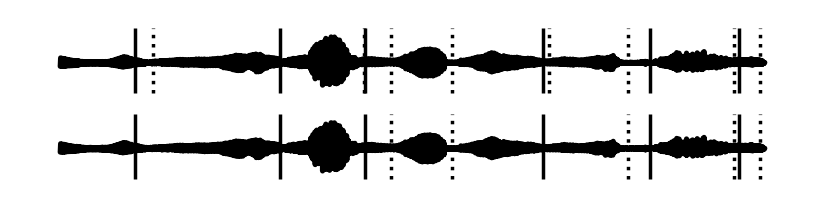

In [ ]:
joint_success_waveform_plot()

(-799.95, 16798.95, -0.5699879644811153, 0.6474624185264111)

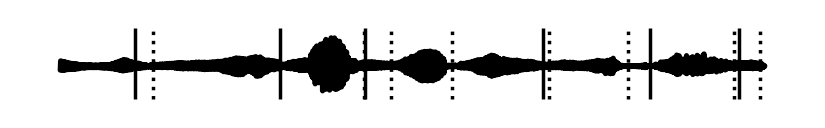

In [ ]:
plt.rcParams["figure.figsize"] = (4,2.5/6)
i = 1
start, stop = (16000*i,16000*(i+1))
transcribed_bound_mask = np.where((transcribed_boundaries<stop)&(transcribed_boundaries>start))[0]
mask = np.where((boundaries<stop)&(boundaries>start))[0]
mask_t = np.where(df['pred'].values[mask]>0.37)[0]
mask_f = np.where(df['pred'].values[mask]<=0.37)[0]
i = i - begin_range
chunk = audio_array[start:stop]
plt.plot(chunk, c='black', alpha=1)
plt.vlines(transcribed_boundaries[transcribed_bound_mask]-start, min(chunk)*(1.35), max(chunk)*(1.35), linewidth=1,zorder=5,color='black', label='true')
plt.vlines(boundaries[mask][mask_t]-start, min(chunk)*(1.35), max(chunk)*(1.35), linestyles=':', linewidth=1,zorder=3,color='black', label='pred')
# axs[i].vlines(boundaries[mask][mask_f]-start, min(chunk)*(1.35), max(chunk)*(1.35), linestyles=':', linewidth=1,zorder=3,color='red', label='pred')
plt.axis('off')

In [ ]:
boundaries[-1]

1667.014

In [ ]:
preds

array([0.42756245, 0.48549858, 0.84408   , ..., 0.25021777, 0.1543543 ,
       0.04642138], dtype=float32)